In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 이미지 데이터 생성기 설정
train_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/Training/1차 검수/split_data/train"
val_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/Training/1차 검수/split_data/val"
test_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/Training/1차 검수/split_data/test"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 생성기
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
    ,color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')



Found 51454 images belonging to 7 classes.
Found 11026 images belonging to 7 classes.
Found 11026 images belonging to 7 classes.


In [2]:
print(tf.__version__)

2.10.0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6315959283707105124
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5758779392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3253755745423860738
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [7]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential


# CNN 모델 구성
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = "saved_models/v2_with_new_data_best_model.hdf5"
checkpoint_cb = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True,monitor='val_loss')
early_stop_cb = EarlyStopping(patience=10,restore_best_weights=True)

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint_cb,early_stop_cb])

Epoch 1/50
1606/1607 [============================>.] - ETA: 0s - loss: 1.4927 - accuracy: 0.4317
Epoch 1: val_loss improved from inf to 1.50130, saving model to saved_models\v2_with_new_data_best_model.hdf5
1607/1607 [==============================] - 82s 46ms/step - loss: 1.4925 - accuracy: 0.4318 - val_loss: 1.5013 - val_accuracy: 0.4654
Epoch 2/50
1607/1607 [==============================] - ETA: 0s - loss: 1.1376 - accuracy: 0.5716
Epoch 2: val_loss improved from 1.50130 to 1.09130, saving model to saved_models\v2_with_new_data_best_model.hdf5
1607/1607 [==============================] - 69s 43ms/step - loss: 1.1376 - accuracy: 0.5716 - val_loss: 1.0913 - val_accuracy: 0.6001
Epoch 3/50
1607/1607 [==============================] - ETA: 0s - loss: 1.0287 - accuracy: 0.6163
Epoch 3: val_loss improved from 1.09130 to 1.01678, saving model to saved_models\v2_with_new_data_best_model.hdf5
1607/1607 [==============================] - 68s 42ms/step - loss: 1.0287 - accuracy: 0.6163 - val

In [11]:
model.evaluate(test_generator)


345/345 [==============================] - 13s 38ms/step - loss: 0.6975 - accuracy: 0.7672


[0.6975141167640686, 0.7671866416931152]

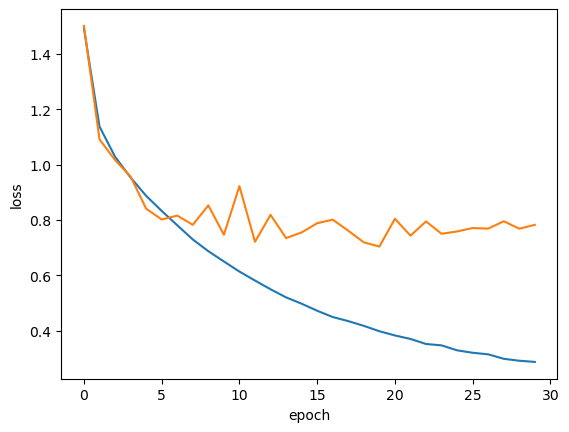

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

In [16]:
from PIL import Image
import numpy as np
classes = ["분노","슬픔","불안","상처","당황","기쁨","중립"]
img = Image.open('test_images\jin_young1.png')
img = img.resize((48, 48)).convert('L')
img_array = np.array(img) / 255.0 
img_array = img_array.reshape(1, 48, 48, 1)
prediction = model.predict(img_array)
print(prediction)
result = classes[np.argmax(prediction, axis=1)[0]]

print(result)


1/1 [==============================] - 0s 25ms/step
[[2.9638849e-04 6.7701675e-02 8.4385854e-01 5.0272100e-02 2.0759452e-02
  1.7067680e-02 4.4132848e-05]]
불안
